# CAB420, Week 4 Practical, Question 1 Template
## Kuzushiji-MNIST and Kuzushiji-MNIST-49

The Kuzushiji-MNIST database is a MNIST like database based on Japanese Kuzushiji characters. Following the pattern of MNIST, it contains gresyscale images of size 28x28 pixels for 10 Kuzushiji characters. A second expanded dataset, Kuzushiji-MNIST-49, has the same format but 49 different characters. The dataset is also imbalanced, in that not every class has the same number of instances and some classes are rarer than others. Using these two datasets:
* Create and train a network to classify the Kuzushiji-MNIST database into it's 10 classes. Evaluate the network on the test set.
* Extend the network to classify the Kuzushiji-MNIST-49 dataset into it's 49 classes. Evaluate the network on the test set, and consider the frequency with which each class occurs when analysing results.

Note that you do not need to try to make your networks overly complex, or train them for more than a few minutes. Smaller networks and training times of 5-10 epochs will be sufficient for this practical. However you are encouraged to experiment with different architectures and explore how they impact performance.

### Relevant Examples

The first deep learning example, ``CAB420_DCNNs_Example_1_Classification_with_Deep_Learning.ipynb`` is a useful starting point here. 

There is also relevant content in ``CAB420_DCNNs_Additional_Example_3_Training_Parameters.ipynb`` with regards to training parameters, and ``CAB420_DCNNs_Additional_Example_4_Layer_Order_and_Overfitting.ipynb`` for various layers and other things that can be done to deal with overfitting. 

### Suggested Packages

We're using tensor flow and keras here. sklearn and matplotlib provide some supporting functionality.

In [6]:
import os
# why is this here? This is disabling some tensorflow warning I get in some of my environments that 
# annoy me (look ugly and untidy really)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
# function to compute class weights
from sklearn.utils import compute_class_weight

import matplotlib.pyplot as plt

import scipy.io
import numpy

### Part 1: K-MNIST
Data loading. Using scipy to load the data. The data is stored as mat files (as is MATLAB), but this is easy to load in python. We'll do a quick sanity check/visualisation of the data.

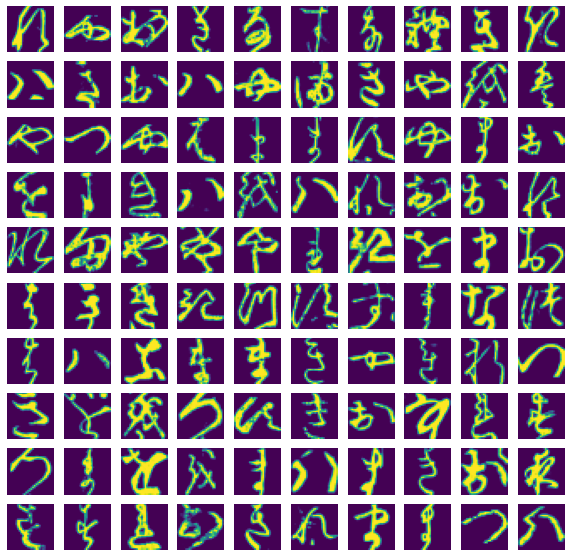

In [7]:
kmnist_train = scipy.io.loadmat('../../data/kmnist/kmnist_train.mat')
kmnist_test = scipy.io.loadmat('../../data/kmnist/kmnist_test.mat')

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(kmnist_train['imgs'][:,:,i])
    ax.axis('off')

Have a quick look at the data. It's always good to make sure we have what we expect.

In [8]:
print(numpy.shape(kmnist_train['imgs']))
print(numpy.shape(kmnist_train['labels']))

(28, 28, 50000)
(50000, 1)


We need to reshape our data so such that the first index is the sample index, and convert it into a 4D structure

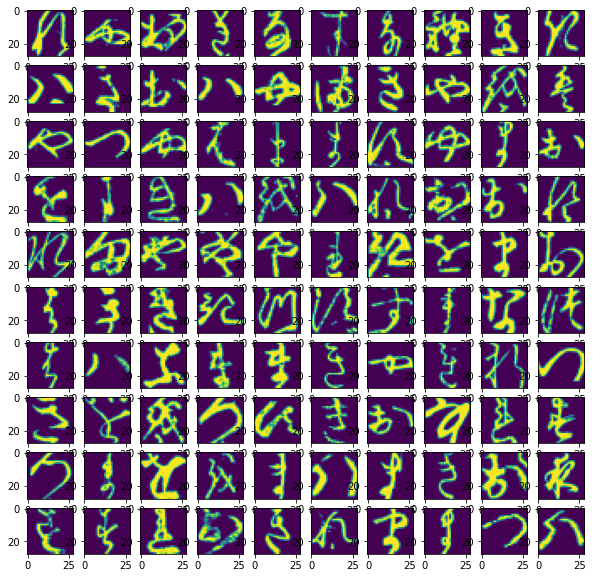

In [4]:
train = numpy.transpose(kmnist_train['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
train_y = kmnist_train['labels']
test = numpy.transpose(kmnist_test['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
test_y = kmnist_test['labels']

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,0])
    ax.axis('off')    

### Part 2: The Network

Define your network here. You do not need to put this in a function, but you can. Using a function like that below will make it easy to re-create the network for 49 classes later.

You are encouraged to explore different options here with respect to your network. A suggested approach would be:
* Start simple, with just a few layers and something that trains fast. Really, just start by getting something working.
* Add a few more computional layers, see how performance changes.
* Add in layers such as batchnormalistaion, and/or dropout. Consider changing activations in the network. What happens if you replace the relu activations with a swish?

#### A note on activations at the last layer

In a number of examples we've used this loss: ``SparseCategoricalCrossentropy(from_logits=True)``. 

The ``SparseCategoricalCrossentropy`` loss **does not** require us to convert the y-data to a one-hot representation, i.e. it remains as single digits (0, 1, 2, ...) to represent the class. Aside from meaning that we don't have to convert the data, which we could do with ``tensorflow.keras.utils.to_categorical`` it also simplifies our generation of things like the confusion matrix.

The ``from_logits=True`` indicates that we're passing un-normalised values from the loss function, i.e. they have not been through a softmax activation. If you have a softmax activation, you should use ``from_logits=False``. Using ``from_logits=False`` **without** a softmax activation in place will usually still work fine, but not always.

If you use ``CategoricalCrossentropy`` as your loss, then you need to convert the y-data to a one-hot representation first.

In [9]:
num_epochs = 5

# function to build a model, takes the number of classes. Can optionally change the output activation. 
def build_model(num_classes, output_activation=None):

    # our model, input in an image shape
    inputs = keras.Input(shape=(28, 28, 1, ), name='img')

    # put your main network layers in here
    
    # output layer 
    outputs = layers.Dense(num_classes, activation=output_activation)(x)

    # build the model, and print a summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='kmnist_cnn_model')
    
    return model_cnn

# build model and print the summary as a sanity check
model_cnn = build_model(10)
model_cnn.summary()

NameError: name 'x' is not defined

#### Train the model

Train your model. You may wish to experiment with different optmisers, and see what metrics you can get out of Keras (see https://keras.io/api/metrics/)

### Part 3: Evaluate the Results

A sample function to plot results is provided, based on lecture examples. Feel free to adapt this. You may wish to:
* Plot other metrics, if you are tracking them
* Look at performance on the training set as well
* Switch to seaborn to show the confusion matrix (it is, perhaps, prettier; and has more colour options)
* Just do something else

In [10]:
def eval_model(model, history, x_train, y_train, x_test, y_test):

    fig = plt.figure(figsize=[20, 6])    

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history['loss'], label='Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.plot(history['accuracy'], label='Accuracy')
    ax.plot(history['val_accuracy'], label='Validation Accuracy')
    ax.legend()
    
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, indexes)

    ax = fig.add_subplot(1, 2, 2)
    c = ConfusionMatrixDisplay(cm, display_labels=range(len(numpy.unique(y_test))))
    c.plot(ax = ax)
    
    print(classification_report(y_test, indexes))

eval_model(model_cnn, history.history, train, train_y, test, test_y)

NameError: name 'model_cnn' is not defined

### Part 4: K-MNIST 49

49 class version now.

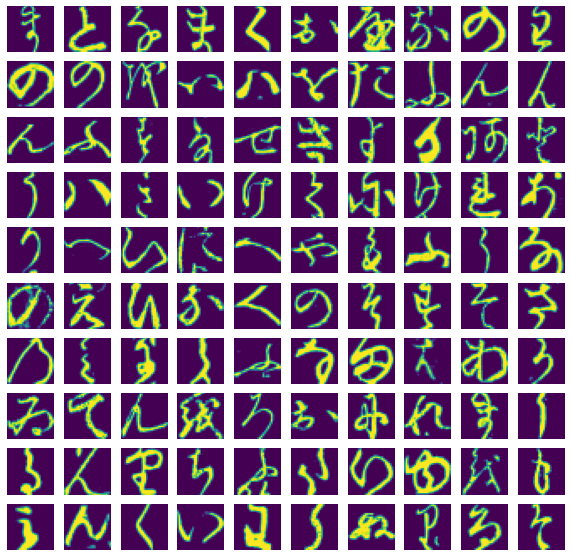

In [11]:
kmnist_train = scipy.io.loadmat('../../data/kmnist/kmnist49_train.mat')
kmnist_test = scipy.io.loadmat('../../data/kmnist/kmnist49_test.mat')
train = numpy.transpose(kmnist_train['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
train_y = kmnist_train['labels']
test = numpy.transpose(kmnist_test['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
test_y = kmnist_test['labels']

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,0])
    ax.axis('off')

### Part 5: Build, train and evaluate the model

You can follow what you did in the earlier parts, but just with the different dataset

### Part 6: Adjusting Class Weights

We can use ``sklearn.utils.compute_class_weight`` to get the class weight for us. Note that this will return a list of weights, while keras will want a dictionary organised by class label (i.e {0: wieght_for_class_0, 1: weight_for_class_1, etc.}).

Add these into the model when you call the fit function. Re-create and re-train the model and see how the results change.